In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision.utils import make_grid
from skimage import io

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
import pandas as pd
from cutmix import CutMixCollator, CutMixCriterion
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PetsDataset(Dataset):
    #CLASS-ID 1-37 different breeds 
    def __init__(self,image_dir: str,annotation_dir: str, train: bool,test:bool,val:bool,transform):
        super().__init__()

        if train:
            self.data = pd.read_csv(os.path.join(annotation_dir,"train.txt"),delimiter=" ",header=None)
        elif val:
            self.data = pd.read_csv(os.path.join(
                annotation_dir, "val.txt"), delimiter=" ")
        else:
            self.data = pd.read_csv(os.path.join(
                annotation_dir, "test.txt"), delimiter=" ")
        
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.test = test
        self.val = val


        
    def __len__(self):

        return self.data.shape[0]
    
    def __getitem__(self,idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.test:

            image_pth = os.path.join(self.image_dir,self.data.iloc[idx,0] + '.jpg')
        else:

            image_pth = os.path.join(self.image_dir, self.data.iloc[idx, 0])
            
        image = Image.open(image_pth).convert("RGB")
     
        if self.train or self.val:
            label = int(self.data.iloc[idx, 1]) - 1
        else:
            label = int(self.data.iloc[idx, 2]) - 1

        
        if self.transform:

            image = self.transform(image)

        
        return image,label

In [4]:
USE_CUTMIX = True

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(256),
    transforms.GaussianBlur(kernel_size=5),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Implementation from https://github.com/hysts/pytorch_cutmix

if USE_CUTMIX:
    collator = CutMixCollator(1.0)
else:
    collator = torch.utils.data.dataloader.default_collate
#Initialise Dataset
pets_dataset_train = PetsDataset(image_dir="data_augmentation/images/", annotation_dir="data_augmentation/",
                                 train=True, val=False, test=False, transform=transform)
pets_dataset_val = PetsDataset(image_dir="data_augmentation/images/", annotation_dir="data_augmentation/",
                               train=False, val=True, test=False, transform=transform_test)

pets_dataset_test = PetsDataset(image_dir="data/images/", annotation_dir="data_augmentation/",
                               train=False, val=False, test=True, transform=transform_test)


In [6]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


In [7]:
BATCH_SIZE = 32
NUM_WORKERS = 8
SHUFFLE = True

# #Dataloader
train_loader = DataLoader(pets_dataset_train, batch_size=BATCH_SIZE, shuffle=SHUFFLE, collate_fn=collator)
test_loader = DataLoader(pets_dataset_test,batch_size=10,shuffle=SHUFFLE)
val_loader = DataLoader(pets_dataset_val,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

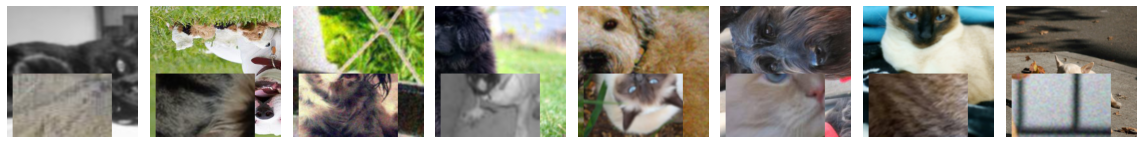

In [8]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


# Get a batch of training data and displaying it
image, label = next(iter(train_loader))
show_grid(image, titles=None)



# Main Code

In [11]:
def save_model(model, optimizer, epoch, stats,name):
    """ Saving model checkpoint """

    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}_{name}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]]
                       )  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [12]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    count = 0
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device).long()
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
        count+=1
          
    # Total correct predictions and loss
    accuracy = (correct / len(eval_loader.dataset)) * 100
    
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, val_criterion, train_criterion, train_loader, valid_loader, num_epochs,name):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=val_criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=train_criterion, epoch=epoch, device=device
            )
            
        if scheduler is not None:

            scheduler.step()
        
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy} %")
            print("\n")
    
    print(f"Training completed")
    print(f"    Accuracy: {accuracy} %")
    stats = {'train_loss': train_loss,
             'val_loss': val_loss,
             'loss_iters': loss_iters,
             'val_accuracy': valid_acc}


    save_model(model, optimizer,epoch,stats,name)
    return train_loss, val_loss, loss_iters, valid_acc

def test_model(model):

    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100

    return accuracy


# Training

In [13]:
set_random_seed()

In [ ]:
#Loading Pretrained Network
model_Fe = torchvision.models.resnet50(pretrained=True)
# freezing the grad for feature extraction
for param in model_Fe.parameters():
    param.requires_grad = False

#Modifying the last layer of the Network

in_features_fc = model_Fe.fc.in_features
model_Fe.fc = nn.Linear(in_features_fc, 2)

model_Fe.to(device)


In [ ]:
if USE_CUTMIX:
    train_criterion = CutMixCriterion(reduction='mean')
else:
    train_criterion = nn.CrossEntropyLoss()

val_criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_Fe = torch.optim.Adam(model_Fe.parameters(), lr=3e-5)


#Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Fe, step_size=10, gamma=0.1)


In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
    model=model_Fe, optimizer=optimizer_Fe, scheduler=scheduler, val_criterion=val_criterion, train_criterion=train_criterion,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20, name="resnet50FE_augment"
)

del model_Fe


In [ ]:
#Loading Pretrained Network
model = torchvision.models.resnet50(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model.fc.in_features
model.fc = nn.Linear(in_features_fc, 2)

model.to(device)


In [ ]:
if USE_CUTMIX:
    train_criterion = CutMixCriterion(reduction='mean')
else:
    train_criterion = nn.CrossEntropyLoss()

val_criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


#Learning rate scheduling
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
    model=model, optimizer=optimizer, scheduler=scheduler, val_criterion=val_criterion,train_criterion=train_criterion,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20,name="resnet50_augment_new"
)

del model


## Training VGG

In [ ]:
#Loading Pretrained Network
model_vgg = torchvision.models.vgg19_bn(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model_vgg.classifier[6].in_features
model_vgg.classifier[6].fc = nn.Linear(in_features_fc, 2)

model_vgg.to(device)


In [ ]:

if USE_CUTMIX:
    train_criterion_vgg = CutMixCriterion(reduction='mean')
else:
    train_criterion_vgg = nn.CrossEntropyLoss()

val_criterion_vgg = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=3e-4)


#Learning rate scheduling
scheduler_vgg = torch.optim.lr_scheduler.StepLR(
    optimizer_vgg, step_size=5, gamma=0.1)




In [ ]:


train_loss_vgg, val_loss_vgg, loss_iters_vgg, valid_acc_vgg = train_model(
    model=model_vgg, optimizer=optimizer_vgg, scheduler=scheduler_vgg, val_criterion=val_criterion_vgg, train_criterion=train_criterion_vgg,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20, name="vgg19_bn_augment"
)

del model_vgg


## Training DenseNet

In [ ]:
#Loading Pretrained Network
model_dense = torchvision.models.densenet121(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(in_features_fc, 2)

model_dense.to(device)

In [ ]:
if USE_CUTMIX:
    train_criterion_dense = CutMixCriterion(reduction='mean')
else:
    train_criterion_dense = nn.CrossEntropyLoss()

val_criterion_dense = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_dense = torch.optim.Adam(model_dense.parameters(), lr=3e-6)


#Learning rate scheduling
scheduler_dense = torch.optim.lr_scheduler.StepLR(
    optimizer_dense, step_size=10, gamma=0.1)


In [ ]:
train_loss_vgg, val_loss_vgg, loss_iters_vgg, valid_acc_vgg = train_model(
    model=model_dense, optimizer=optimizer_dense, scheduler=scheduler_dense, val_criterion=val_criterion_dense, train_criterion=train_criterion_dense,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=20, name="dense121_augment"
)

del model_dense


In [15]:
# Model dense

savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_19_dense121_augment_new.pth")

model_dense = torchvision.models.densenet121(pretrained=True)

in_features_fc = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(in_features_fc, 2)
optimizer_dense = torch.optim.Adam(model_dense.parameters(), lr=3e-6)

model_dense.to(device)
model_dense_1, optimizer_dense1, epoch_dense1, stats_dense1 = load_model(
    model=model_dense, optimizer=optimizer_dense, savepath=savepath)


In [14]:
# Model ResNet

savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_19_resnet50_augment_new.pth")

model = torchvision.models.resnet50(pretrained=True)

in_features_fc = model.fc.in_features
model.fc = nn.Linear(in_features_fc, 2)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

model.to(device)

model_resnet1, optimizer_resnet1, epoch_resnet1, stats_resnet1 = load_model(
    model=model, optimizer=optimizer, savepath=savepath)





In [16]:
# Model ResNet Feature extractor

savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_19_fixed_feature_extractor.pth") # edit

model_F = torchvision.models.resnet50(pretrained=True)

in_features_fc = model_F.fc.in_features
model_F.fc = nn.Linear(in_features_fc, 2)

optimizer = torch.optim.Adam(model_F.parameters(), lr=3e-5)

model_F.to(device)

model_resnetFE, optimizer_resnetFE, epoch_resnetFE, stats_resnetFE = load_model(
    model=model_F, optimizer=optimizer, savepath=savepath)


In [17]:
#Model VGG 
savepath = os.path.join(os.getcwd(
), "models/", "checkpoint_epoch_24_vgg16_augment_new.pth")

model_vgg = torchvision.models.vgg16(pretrained=True)

in_features_fc = model_vgg.classifier[6].in_features
model_vgg.classifier[6].fc = nn.Linear(in_features_fc, 2)


optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=3e-4)

model_vgg.to(device)





model_vgg1, optimizer_vgg1, epoch_vgg1, stats_vgg1 = load_model(
    model=model_vgg, optimizer=optimizer_vgg, savepath=savepath)


In [18]:
acc2 = test_model(model_resnet1)

In [19]:
print(acc2)

93.754674644727


In [20]:
acc1 = test_model(model_dense_1)
print(acc1)

88.61256544502618


In [21]:
acc3 = test_model(model_resnetFE)
print(acc3)

90.08975317875841


In [22]:
acc4 = test_model(model_vgg1)
print(acc4)

49.70082273747195


In [23]:
train_losses_resnet = np.array(stats_resnet1['train_loss'],dtype=np.float)
train_losses_resnetfe = np.array(stats_resnetFE['train_loss'],dtype=np.float)
train_losses_dense = np.array(stats_dense1['train_loss'],dtype=np.float)
train_losses_vgg = np.array(stats_vgg1['train_loss'],dtype=np.float)

val_losses_resnet = np.array(stats_resnet1['val_loss'], dtype=np.float)
val_losses_resnetfe = np.array(stats_resnetFE['val_loss'], dtype=np.float)
val_losses_dense  = np.array(stats_dense1['val_loss'],dtype=np.float)
val_losses_vgg  = np.array(stats_vgg1['val_loss'],dtype=np.float)


/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/dhagash/anaconda3/envs/

In [24]:
print(count_model_params(model_resnet1))
print(count_model_params(model_resnetFE))
print(count_model_params(model_dense_1))
print(count_model_params(model_vgg1))

23512130
23512130
6955906
138365738


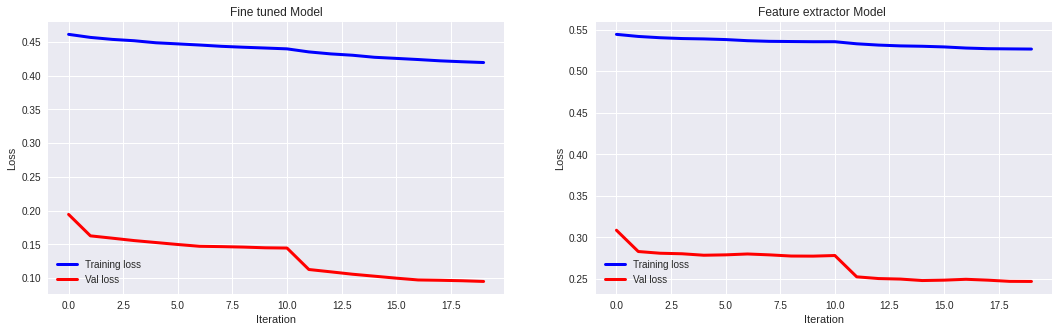

In [25]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)


ax[0].plot(smooth(train_losses_resnet,20), c="blue", label="Training loss", linewidth=3)
ax[0].plot(smooth(val_losses_resnet,20), c="red", label="Val loss", linewidth=3)
ax[0].set_title("Fine tuned Model")
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
# ax[0].set_title("Train/Val Loss")

ax[1].plot(smooth(train_losses_resnetfe,20), c="blue",
           label="Training loss", linewidth=3)
ax[1].plot(smooth(val_losses_resnetfe,20), c="red", label="Val loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_title("Feature extractor Model ")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
# ax[1].set_yscale("log")
# ax[1].set_title("Train/Val Loss")


plt.show()


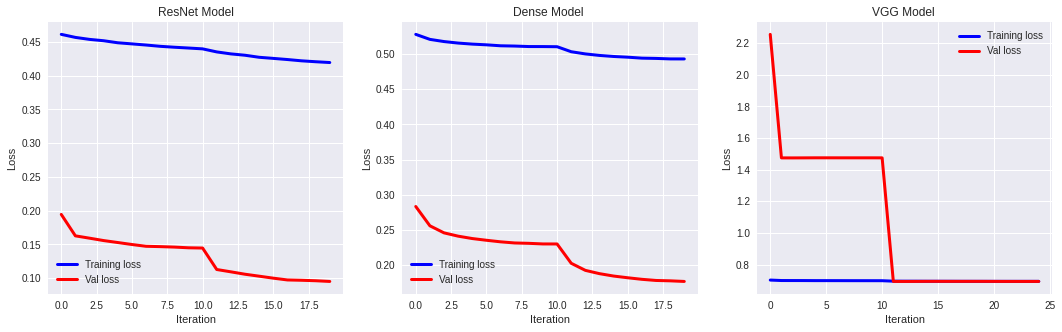

In [26]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 5)


ax[0].plot(smooth(train_losses_resnet, 20), c="blue",
           label="Training loss", linewidth=3)
ax[0].plot(smooth(val_losses_resnet, 20),
           c="red", label="Val loss", linewidth=3)
ax[0].set_title("ResNet Model")
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")


ax[1].plot(smooth(train_losses_dense, 20), c="blue",
           label="Training loss", linewidth=3)
ax[1].plot(smooth(val_losses_dense, 20),
           c="red", label="Val loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_title("Dense Model ")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")

ax[2].plot(smooth(train_losses_vgg, 20), c="blue",
       label="Training loss", linewidth=3)
ax[2].plot(smooth(val_losses_vgg, 20),
       c="red", label="Val loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_title("VGG Model ")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Loss")



plt.show()


**Evaluated on last epoch of training**
- **The plots are looking weird dont really know the reason why?**


$$
\begin{aligned}
& \text {Comparision of accuracy and parameters of different models}\\
&\begin{array}{lcc}
\hline \text { Models } &\text {Accuracy} & \text {Parameters}  \\
\hline \text {ResNet Fine Tuned Model}  & \textbf{93.49}          & 23512130   \\
\text{ResNet Feature Extractor Model}   & 89.21                   & 23512130   \\ 
\text{DenseNet Fine Tuned Model}        & 89.21                   & 6955906   \\
\text{VGG16 Fine Tuned Model}          & 48.24                   & 138365738  \\
\hline
\end{array}
\end{aligned}
$$







- Data augmentation helped quite much although its just a binary classification task the accuracy of above 90% can be achieved in just few epoch
- Advance methods like cutmix imporves training time by a lot 
- The other thing which was key in training was LR schedular and particularly learning rate(forgot to save the models which we tried with different learning rates) but it was matter of almost 20-30% accuracy


**Remarks on Augmentation**

- Increased the dataset by 6x by rotating,flipping, scaling and Gaussian Noise
- Impact can be seen in training time
- One question this dataset would have been much useful for breed classification task as the train data in that has only 4k Images to train for classifying 37 labels? Also how sensitive is training to different augmentation like color or etc? Are there any augmentation that we should avoid while dealing with particular dataset?
- Also are there standard set of augmentations which work good and which should be applied everytime? In brief is there any thumb rule to follow